## ml-zoomcamp midterm project

### setup

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mutual_info_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
!uv run kaggle datasets download \
  mosapabdelghany/student-performance-factors-dataset \
  -p data

Dataset URL: https://www.kaggle.com/datasets/mosapabdelghany/student-performance-factors-dataset
License(s): CC0-1.0
  0%|                                               | 0.00/93.9k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 93.9k/93.9k [00:00<00:00, 374MB/s]


In [4]:
!unzip data/*.zip -d data

Archive:  data/student-performance-factors-dataset.zip
  inflating: data/StudentPerformanceFactors.csv  


In [19]:
df = pd.read_csv("./data/StudentPerformanceFactors.csv")

### EDA

In [111]:
df.head()

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,23,84,low,high,no,7,73,low,yes,0,low,medium,public,positive,3,no,high_school,near,male,67
1,19,64,low,medium,no,8,59,low,yes,2,medium,medium,public,negative,4,no,college,moderate,female,61
2,24,98,medium,medium,yes,7,91,medium,yes,2,medium,medium,public,neutral,4,no,postgraduate,near,male,74
3,29,89,low,medium,yes,8,98,medium,yes,1,medium,medium,public,negative,4,no,high_school,moderate,male,71
4,19,92,medium,medium,yes,6,65,medium,yes,3,medium,high,public,neutral,4,no,college,near,female,70


In [112]:
df.describe()

,hours_studied,attendance,sleep_hours,previous_scores,tutoring_sessions,physical_activity,exam_score
count,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000
mean,19.977109,80.020853,7.034964,75.066165,1.495296,2.972719,67.252117
std,5.985460,11.550723,1.468033,14.400389,1.233984,1.028926,3.914217
min,1.000000,60.000000,4.000000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.000000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.000000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.000000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.000000,100.000000,8.000000,6.000000,101.000000


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   hours_studied               6378 non-null   int64 
 1   attendance                  6378 non-null   int64 
 2   parental_involvement        6378 non-null   object
 3   access_to_resources         6378 non-null   object
 4   extracurricular_activities  6378 non-null   object
 5   sleep_hours                 6378 non-null   int64 
 6   previous_scores             6378 non-null   int64 
 7   motivation_level            6378 non-null   object
 8   internet_access             6378 non-null   object
 9   tutoring_sessions           6378 non-null   int64 
 10  family_income               6378 non-null   object
 11  teacher_quality             6378 non-null   object
 12  school_type                 6378 non-null   object
 13  peer_influence              6378 non-null   object
 1

In [114]:
df.duplicated().sum()

np.int64(0)

In [129]:
# Missing value summary
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = (
    pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
    .query("missing_count > 0")
    .sort_values("missing_pct", ascending=False)
)

print(missing_df)

# Check if missingness correlates with target
for col in missing_df.index:
    missing_flag = df[col].isnull()
    print(f"\n{col} missing vs present:")
    print(df.groupby(missing_flag)["exam_score"].agg(["mean", "std", "count"]))

# drop rows
df_clean = df.dropna()
print(f"\nRows after handling missing: {len(df_clean)}")

Empty DataFrame
Columns: [missing_count, missing_pct]
Index: []

Rows after handling missing: 6378


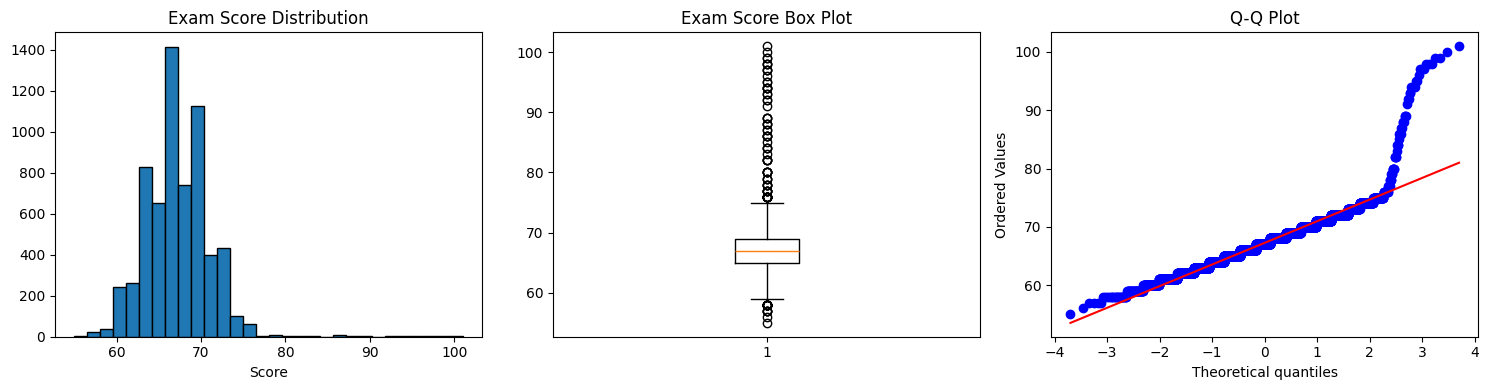

count    6378.000000
mean       67.252117
std         3.914217
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       101.000000
Name: exam_score, dtype: float64

Skewness: 1.666
Kurtosis: 10.656


In [126]:
# 3. Target Variable Analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df_clean["exam_score"], bins=30, edgecolor="black")
axes[0].set_title("Exam Score Distribution")
axes[0].set_xlabel("Score")

axes[1].boxplot(df_clean["exam_score"])
axes[1].set_title("Exam Score Box Plot")

stats.probplot(df_clean["exam_score"], dist="norm", plot=axes[2])
axes[2].set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

print(df_clean["exam_score"].describe())
print(f"\nSkewness: {df_clean['exam_score'].skew():.3f}")
print(f"Kurtosis: {df_clean['exam_score'].kurtosis():.3f}")

In [117]:
categorical = []
numerical = []

for col in df.columns:
    if df[col].dtype == "object":
        categorical.append(col)
    elif df[col].dtype == "int64":
        numerical.append(col)

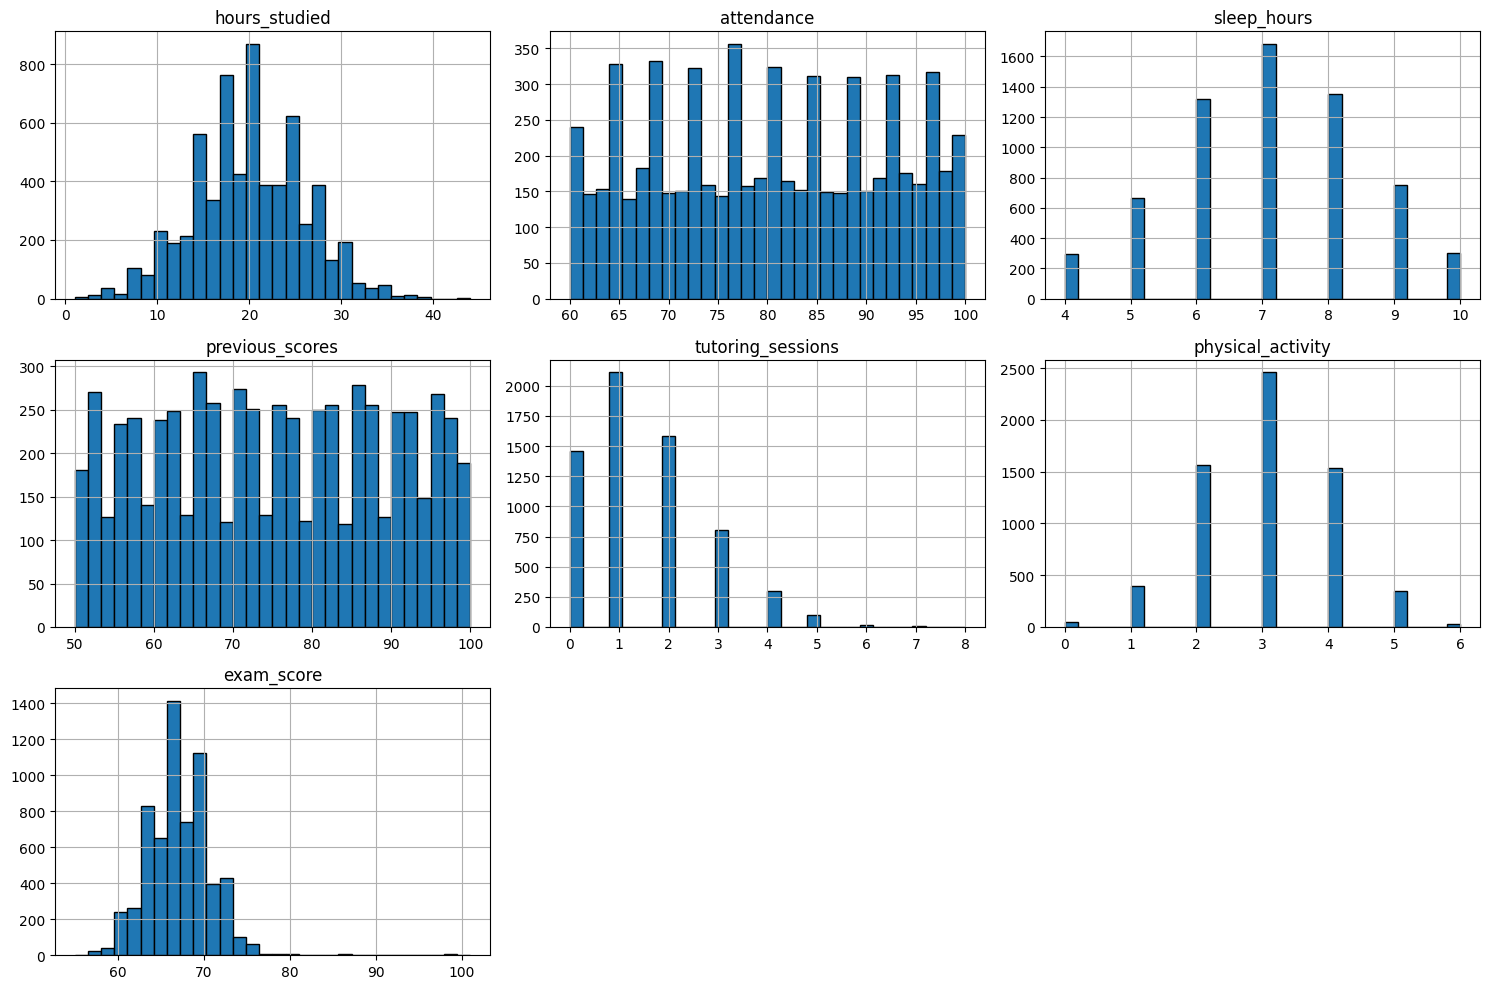

hours_studied: 40 outliers (0.6%)
attendance: 0 outliers (0.0%)
sleep_hours: 0 outliers (0.0%)
previous_scores: 0 outliers (0.0%)
tutoring_sessions: 423 outliers (6.6%)
physical_activity: 0 outliers (0.0%)
exam_score: 103 outliers (1.6%)


In [118]:
# 4. Numerical Features - Distributions
df_clean[numerical].hist(bins=30, figsize=(15, 10), edgecolor="black")
plt.tight_layout()
plt.show()

# Check for outliers
for col in numerical:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (
        (df_clean[col] < Q1 - 1.5 * IQR) | (df_clean[col] > Q3 + 1.5 * IQR)
    ).sum()
    print(f"{col}: {outliers} outliers ({100 * outliers / len(df_clean):.1f}%)")


Correlations with exam_score:
attendance           0.580259
hours_studied        0.445104
previous_scores      0.174283
tutoring_sessions    0.156829
physical_activity    0.025148
sleep_hours         -0.017171
Name: exam_score, dtype: float64


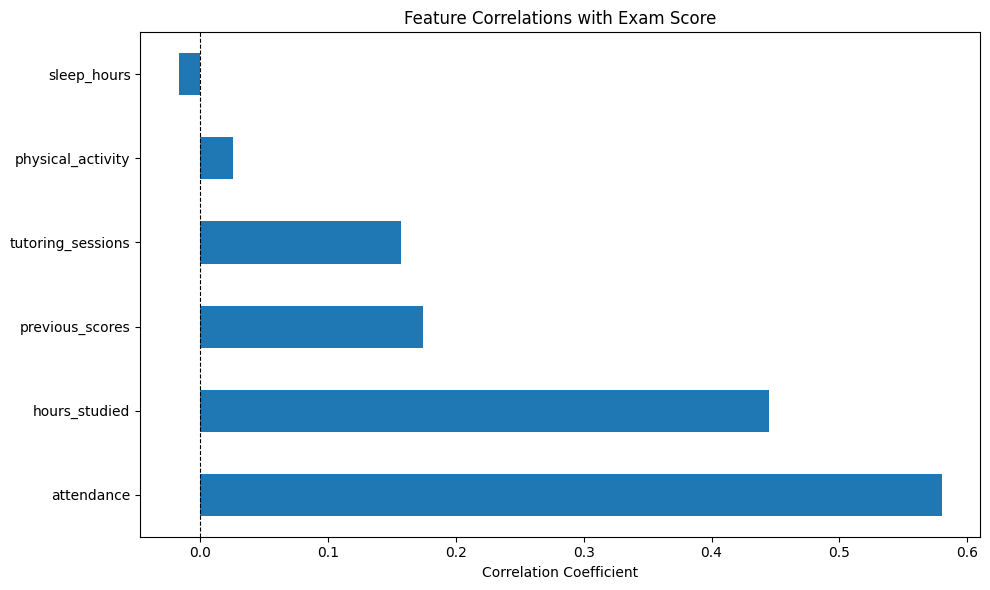

In [119]:
# 5. Correlations with target
correlations = (
    df_clean[numerical]
    .corr()["exam_score"]
    .drop("exam_score")
    .sort_values(ascending=False)
)

print("\nCorrelations with exam_score:")
print(correlations)

plt.figure(figsize=(10, 6))
correlations.plot(kind="barh")
plt.title("Feature Correlations with Exam Score")
plt.xlabel("Correlation Coefficient")
plt.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.tight_layout()
plt.show()

Full correlation matrix:
                   hours_studied  attendance  sleep_hours  previous_scores  \
hours_studied           1.000000   -0.004997     0.013119         0.022492   
attendance             -0.004997    1.000000    -0.019602        -0.018083   
sleep_hours             0.013119   -0.019602     1.000000        -0.023238   
previous_scores         0.022492   -0.018083    -0.023238         1.000000   
tutoring_sessions      -0.009654    0.012070    -0.011466        -0.013158   
physical_activity       0.003183   -0.022976    -0.002898        -0.006694   
exam_score              0.445104    0.580259    -0.017171         0.174283   

                   tutoring_sessions  physical_activity  exam_score  
hours_studied              -0.009654           0.003183    0.445104  
attendance                  0.012070          -0.022976    0.580259  
sleep_hours                -0.011466          -0.002898   -0.017171  
previous_scores            -0.013158          -0.006694    0.174283  


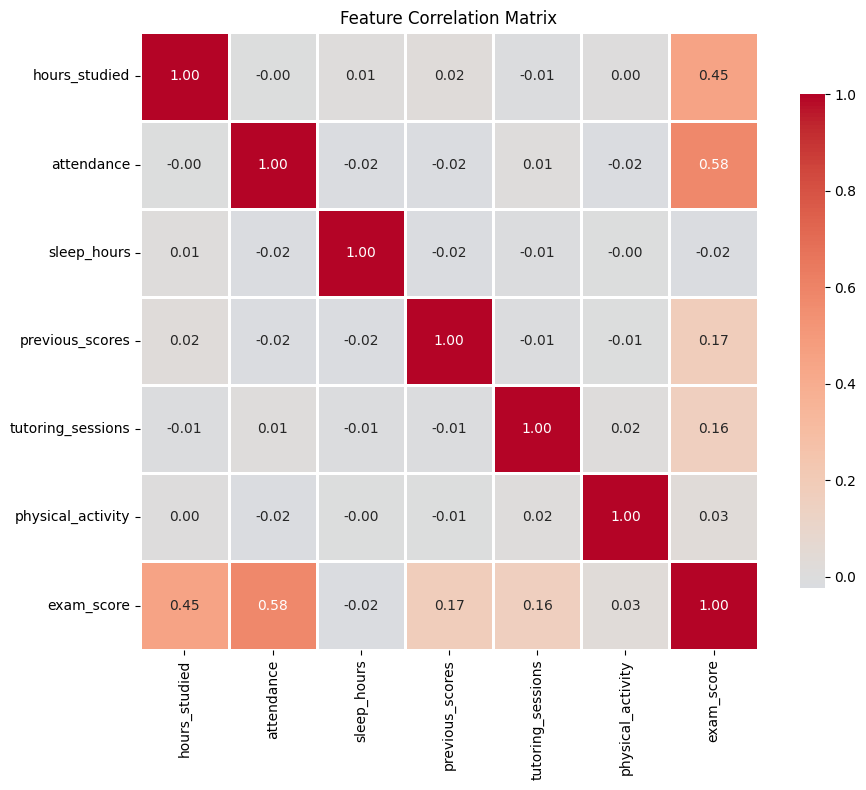

In [120]:
# 6. Multicollinearity check
corr_matrix = df_clean[numerical].corr()

# Print the full correlation matrix
print("Full correlation matrix:")
print(corr_matrix)

# High correlations (potential multicollinearity)
print("\n" + "=" * 60)
print("HIGH CORRELATIONS CHECK (|r| > 0.7)")
print("=" * 60)

high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
            print(
                f"{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_val:.3f}"
            )

if not high_corr:
    print("No high correlations found (no multicollinearity issues)")

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [121]:
for col in categorical:
    print(df_clean[col].value_counts())
    print(f"\nMean exam score by {col}:")
    print(df_clean.groupby(col)["exam_score"].mean().sort_values(ascending=False))
    print("\n")

parental_involvement
medium    3251
high      1836
low       1291
Name: count, dtype: int64

Mean exam score by parental_involvement:
parental_involvement
high      68.112200
medium    67.113196
low       66.378776
Name: exam_score, dtype: float64


access_to_resources
medium    3204
high      1900
low       1274
Name: count, dtype: int64

Mean exam score by access_to_resources:
access_to_resources
high      68.103158
medium    67.156367
low       66.223705
Name: exam_score, dtype: float64


extracurricular_activities
yes    3807
no     2571
Name: count, dtype: int64

Mean exam score by extracurricular_activities:
extracurricular_activities
yes    67.454951
no     66.951770
Name: exam_score, dtype: float64


motivation_level
medium    3237
low       1864
high      1277
Name: count, dtype: int64

Mean exam score by motivation_level:
motivation_level
high      67.743931
medium    67.338894
low       66.764485
Name: exam_score, dtype: float64


internet_access
yes    5893
no      485
Name

In [127]:
# Get all features except target
all_features = numerical + categorical
all_features = [f for f in all_features if f != "exam_score"]

# Encode categorical features for MI calculation
df_encoded = df_clean.copy()

for col in categorical:
    if col in df_encoded.columns and col != "exam_score":
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Calculate MI for all features
mi_scores = mutual_info_regression(
    df_encoded[all_features], df_encoded["exam_score"], random_state=42
)

# Create ranked dataframe
mi_df = pd.DataFrame({"feature": all_features, "mi_score": mi_scores}).sort_values(
    "mi_score", ascending=False
)

print("Mutual Information Scores (all features):")
print(mi_df)

Mutual Information Scores (all features):
                       feature  mi_score
1                   attendance  0.312864
0                hours_studied  0.162438
16    parental_education_level  0.028051
3              previous_scores  0.021301
4            tutoring_sessions  0.015194
17          distance_from_home  0.012888
8   extracurricular_activities  0.010714
18                      gender  0.009930
7          access_to_resources  0.007057
9             motivation_level  0.005768
6         parental_involvement  0.005532
10             internet_access  0.005055
12             teacher_quality  0.002717
2                  sleep_hours  0.000000
5            physical_activity  0.000000
14              peer_influence  0.000000
13                 school_type  0.000000
11               family_income  0.000000
15       learning_disabilities  0.000000


## pipeline

In [42]:
def prepare_data(df):
    """
    Takes dataframe, shares key info & completes basic transformations
    """

    df = df.copy()

    print(f"dataset shape: {df.shape}")
    print(f"total duplicates: {df.duplicated().sum()}")
    print(f"total null values: {df.isnull().sum()}")

    # change column names to lowercase and remove spaces
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    print(f"column names: {df.columns}")

    # remove spaces in object columns
    strings = list(df.dtypes[df.dtypes == "object"].index)

    # drop empty columns
    df = df.dropna()

    for col in strings:
        df[col] = df[col].str.lower().str.replace(" ", "_")

    # sort features into categorical & numerical based on data type
    categorical = []
    numerical = []

    for col in df.columns:
        if df[col].dtype == "object":
            categorical.append(col)
        elif df[col].dtype == "int64":
            numerical.append(col)

    return categorical, numerical, df

In [67]:
def create_framework(df):
    """
    Takes dataframe, shares key info & completes basic transformations
    """

    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.exam_score.values
    y_val = df_val.exam_score.values
    y_test = df_test.exam_score.values

    del df_train["exam_score"]
    del df_val["exam_score"]
    del df_test["exam_score"]

    print(
        f"training/validation/testing length: {len(df_train)}/{len(df_val)}/{len(df_test)}"
    )

    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test

In [76]:
def encode_features(df_train, df_val, df_test):
    """
    One-hot encode categorical features, keep numerical as-is
    """

    # convert to dictionaries
    train_dicts = df_train.to_dict(orient="records")
    val_dicts = df_val.to_dict(orient="records")
    test_dicts = df_test.to_dict(orient="records")

    # fit encoder on training data
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dicts)

    # transform all datasets
    X_train = dv.transform(train_dicts)
    X_val = dv.transform(val_dicts)
    X_test = dv.transform(test_dicts)

    print(f"Original df_train shape: {df_train.shape}")
    print(f"Encoded X_train shape: {X_train.shape}")
    print(f"\nFeature names (first 20): {dv.get_feature_names_out()[:20]}")

    return dv, X_train, X_val, X_test

In [81]:
def select_features(dv, X_train, y_train, X_val, X_test, threshold=0.01):
    """
    Calculate MI scores and keep only features above threshold
    """

    # calculate MI for all encoded features
    mi_scores = mutual_info_regression(X_train, y_train, random_state=42)

    # get feature names
    feature_names = dv.get_feature_names_out()

    # show MI scores
    mi_df = pd.DataFrame({"feature": feature_names, "mi_score": mi_scores}).sort_values(
        "mi_score", ascending=False
    )

    print("MI Scores for all features:")
    print(mi_df)

    # keep features above threshold
    keep_indices = mi_scores > threshold

    print(f"\nKeeping {keep_indices.sum()} features out of {len(feature_names)}")
    print(f"Dropped features with MI < {threshold}")

    # keep selected features
    X_train_selected = X_train[:, keep_indices]
    X_val_selected = X_val[:, keep_indices]
    X_test_selected = X_test[:, keep_indices]

    print("Shape after feature selection:")
    print(f"X_train: {X_train_selected.shape}")
    print(f"X_val: {X_val_selected.shape}")
    print(f"X_test: {X_test_selected.shape}")

    return X_train_selected, X_val_selected, X_test_selected

In [130]:
def train_model(X_train, y_train, model_type="linear", **params):
    """
    Train regression model
    """

    if model_type == "linear":
        model = LinearRegression()

    elif model_type == "ridge":
        alpha = params.get("alpha", 1.0)
        model = Ridge(alpha=alpha)

    elif model_type == "random_forest":
        n_estimators = params.get("n_estimators", 100)
        max_depth = params.get("max_depth", 10)
        model = RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth, random_state=1, n_jobs=-1
        )

    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    model.fit(X_train, y_train)

    return model

In [125]:
def tune_random_forest(X_train, y_train, X_val, y_val):
    """
    Grid search to find best Random Forest parameters
    """
    import numpy as np
    from sklearn.metrics import mean_squared_error

    rf_params = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_leaf": [1, 2, 5],
    }

    best_rmse = float("inf")
    best_params = {}
    best_model = None

    print("Testing Random Forest parameters:\n")

    for n_est in rf_params["n_estimators"]:
        for depth in rf_params["max_depth"]:
            for min_leaf in rf_params["min_samples_leaf"]:
                model = train_model(
                    X_train,
                    y_train,
                    model_type="random_forest",
                    n_estimators=n_est,
                    max_depth=depth,
                    min_samples_leaf=min_leaf,
                )

                y_pred = model.predict(X_val)
                rmse = np.sqrt(mean_squared_error(y_val, y_pred))

                print(
                    f"n_est={n_est}, depth={depth}, min_leaf={min_leaf} -> RMSE: {rmse:.3f}"
                )

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = best_params
                    best_model = model

    print(f"\nBest params: {best_params}, Best RMSE: {best_rmse:.3f}")

    return best_model, best_params

In [107]:
def evaluate_model(model, X, y, dataset_name="Validation"):
    """
    Evaluate model performance
    """

    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    print(f"{dataset_name} Results:")
    print(f"RMSE: {rmse:.3f}")
    print(f"R² Score: {r2:.3f}")

    return y_pred

In [ ]:
# MODEL TRAINING & EVALUATION PIPELINE

# 1-4: Data prep
df = pd.read_csv("./data/StudentPerformanceFactors.csv")
categorical, numerical, df = prepare_data(df)
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = create_framework(df)
dv, X_train, X_val, X_test = encode_features(df_train, df_val, df_test)
X_train, X_val, X_test = select_features(
    dv, X_train, y_train, X_val, X_test, threshold=0.01
)

# 5: Test all models
print("=" * 60)
print("LINEAR REGRESSION")
print("=" * 60)
lr_model = train_model(X_train, y_train, model_type="linear")
evaluate_model(lr_model, X_val, y_val, "Validation")

print("\n" + "=" * 60)
print("RIDGE REGRESSION")
print("=" * 60)
for alpha in [0.01, 0.1, 1, 10, 100]:
    ridge_model = train_model(X_train, y_train, model_type="ridge", alpha=alpha)
    print(f"\nAlpha = {alpha}")
    evaluate_model(ridge_model, X_val, y_val, "Validation")

print("\n" + "=" * 60)
print("RANDOM FOREST TUNING")
print("=" * 60)
rf_model, rf_params = tune_random_forest(X_train, y_train, X_val, y_val)
evaluate_model(rf_model, X_val, y_val, "Validation - Best RF")

# 6: Final test with best model
print("\n" + "=" * 60)
print("FINAL TEST (LINEAR REGRESSION)")
print("=" * 60)
evaluate_model(lr_model, X_test, y_test, "Test")

dataset shape: (6607, 20)
total duplicates: 0
total null values: Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64
column names: Index(['hours_studied', 'attendance', 'parental_involvement',
       'access_to_resources', 'extracurricular_activities', 'sleep_hours',
       'previous_scores', 'motivation_level', 'internet_access',
       'tutoring_sessions', 'family_income', '

array([68.75935194, 63.88763091, 67.69845873, ..., 69.64801411,
       74.59053478, 70.335691  ], shape=(1276,))